In [1]:
from __future__ import division, print_function

# отключим всякие предупреждения Anaconda
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import pylab as plt

%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)

# Классификация

## Обработка данных

In [2]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics, svm
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    KFold,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)

In [44]:
# Набор данных взят с сайта: 
# https://www.kaggle.com/uciml/breast-cancer-wisconsin-data

df = pd.read_csv("tr.csv", names=["id", "diagnosis", "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
                                      "smoothness_mean", "compactness_mean", "concavity_mean", "concave points_mean",
                                      "symmetry_mean", "fractal_dimension_mean", "radius_se", "texture_se",
                                      "perimeter_se", "area_se", "smoothness_se", "compactness_se", "concavity_se",
                                      "concave points_se", "symmetry_se", "fractal_dimension_se", "radius_worst",
                                      "texture_worst", "perimeter_worst", "area_worst", "smoothness_worst",
                                      "compactness_worst", "concavity_worst", "concave points_worst", "symmetry_worst",
                                      "fractal_dimension_worst"]).dropna()

In [4]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Информация об атрибутах:

1) Идентификационный номер
2) Диагноз (M = злокачественный, B = доброкачественный)
3-32)

Для каждого ядра клетки вычисляются десять действительных признаков:

a) радиус (среднее расстояние от центра до точек по периметру)
b) текстура (стандартное отклонение значений шкалы серого)
c) периметр
d) площадь
e) гладкость (локальное изменение длины радиуса)
f) компактность (периметр ^ 2 / площадь - 1,0)
g) вогнутость (степень вогнутости частей контура)
h ) вогнутые точки (количество вогнутых участков контура)
i) симметрия
j) фрактальная размерность («приближение береговой линии» - 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

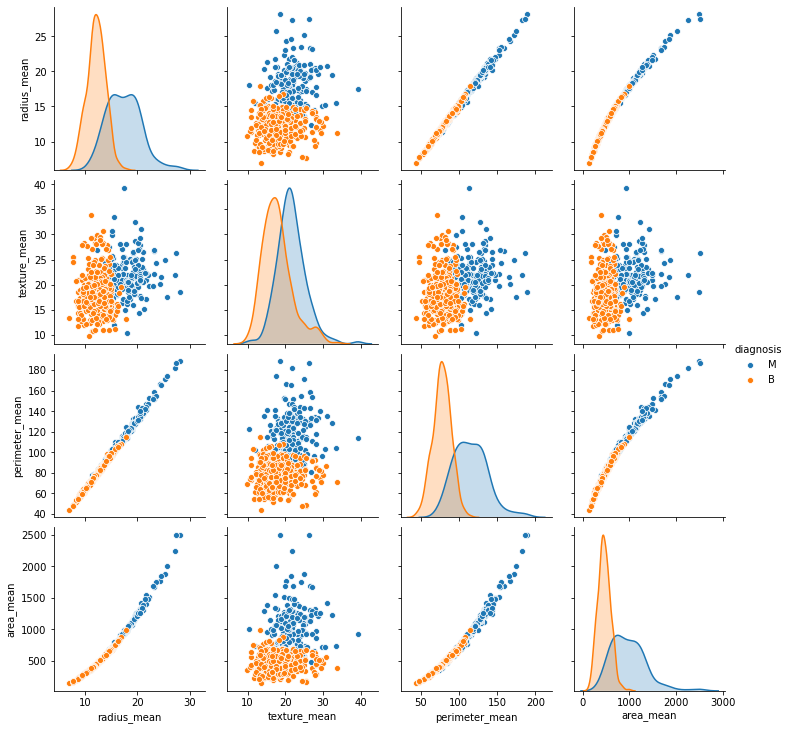

In [6]:
sns.pairplot(df.loc[:,'diagnosis':'area_mean'], hue="diagnosis");

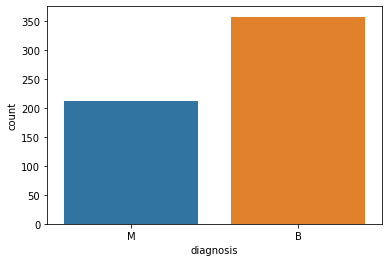

In [45]:
# видим, что целевой параметр в выборке распределён неравномерно
sns.countplot(df["diagnosis"])

In [7]:
Y = df['diagnosis'].map({'M': 1, 'B': 0})
X = df.drop(['diagnosis', 'id'], axis=1)

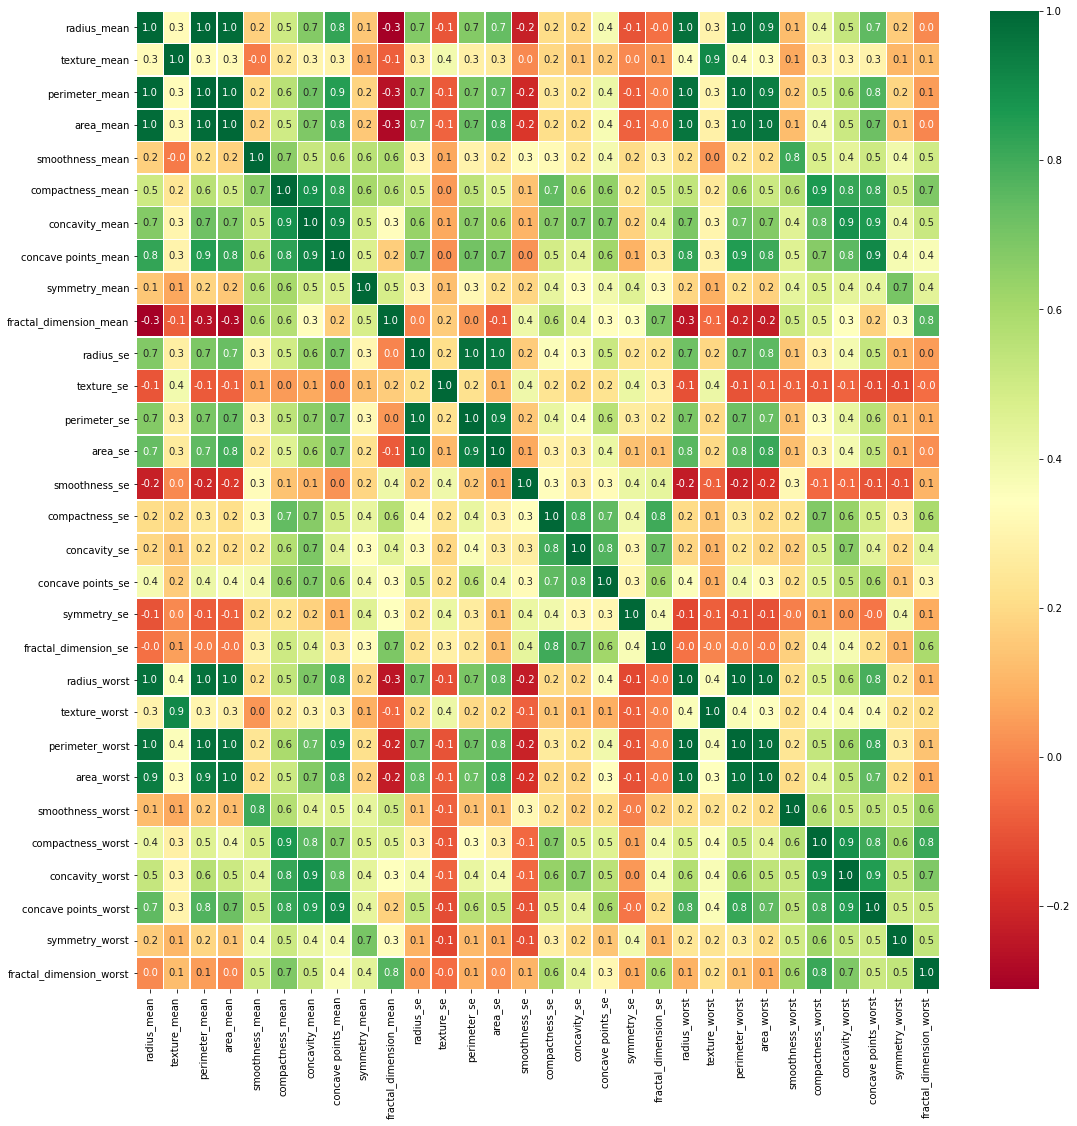

In [8]:
#correlation map
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn", linewidths=.5, fmt= '.1f',ax=ax);

Видим, что radius_mean и perimeter_mean имеют идеальную корреляцию, и это не удивительно, т.к. с помощью радиуса вычисляется периметр. Найдём и уберём некоторые избыточные параметры.

In [9]:
X = X.drop(["radius_mean", "perimeter_mean", "area_mean", "radius_se"], axis=1)

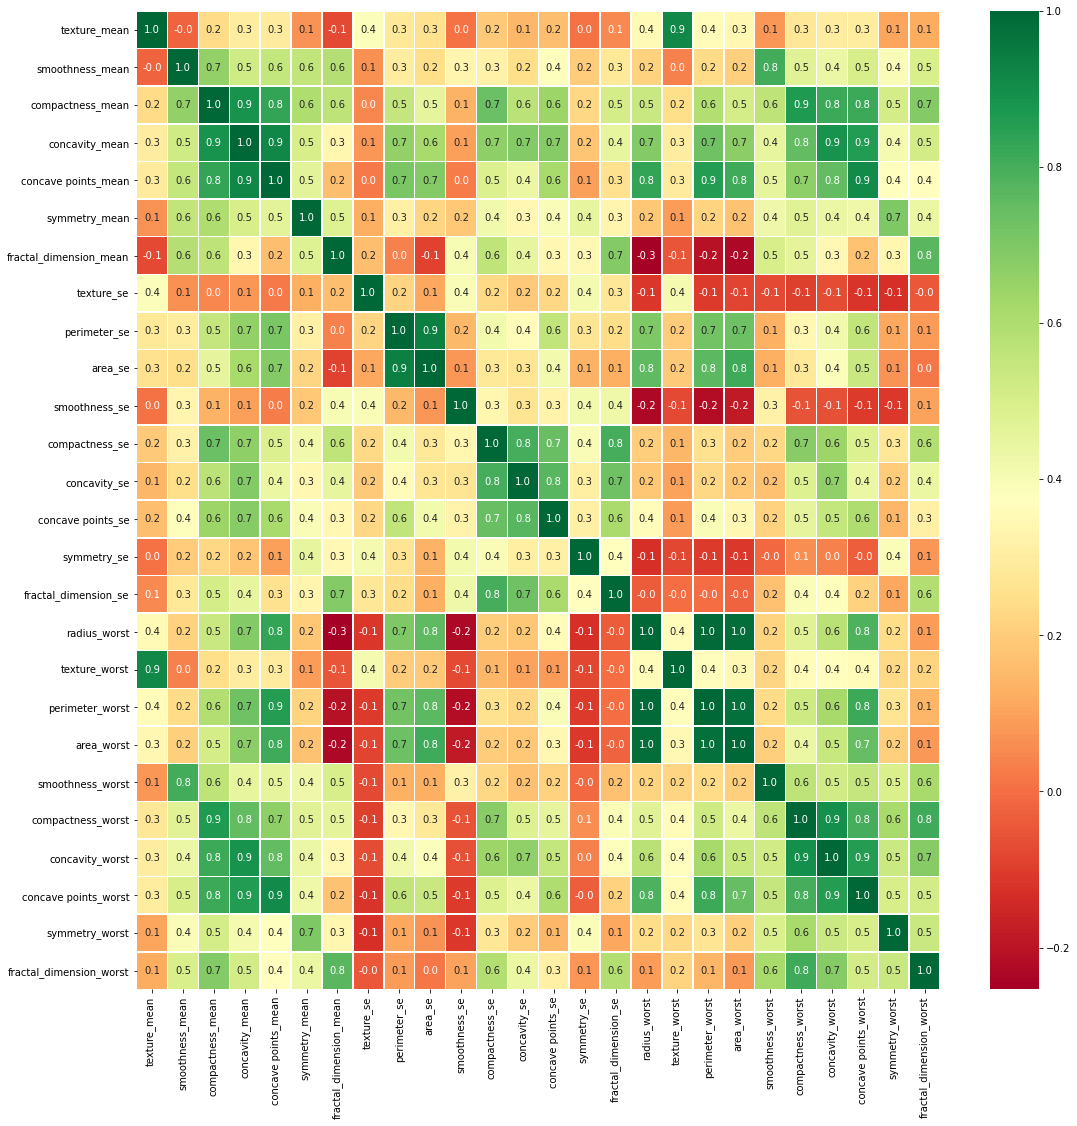

In [10]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(X.corr(), annot=True, cmap="RdYlGn", linewidths=.5, fmt= '.1f',ax=ax);

Выделим 80% выборки (X_train, y_train) под обучение и 20% будут отложенной выборкой (X_test, y_test). отложенная выборка никак не будет участвовать в настройке параметров моделей, на ней мы в конце, после этой настройки, оценим качество полученной модели.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

Создаем и обучаем классификатор:
Основные параметры класса sklearn.neighbors.KNeighborsClassifier:


* weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция 

* algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.

* leaf_size (опционально): порог переключения на полный перебор в случае выбора BallTree или KDTree для 
нахождения соседей

* metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

## kNN

In [12]:
knn_model = KNeighborsClassifier(
   n_neighbors=10, 
   weights='distance',
   algorithm='auto',
   leaf_size=30,
   metric='euclidean',
   metric_params=None,
   n_jobs=-1
)

In [13]:
knn_model.fit(X_train, y_train)

KNeighborsClassifier(metric='euclidean', n_jobs=-1, n_neighbors=10,
                     weights='distance')

In [14]:
knn_pred = knn_model.predict(X_test)
print("Evaluation\t\t\tlabels 'M': 1, 'B': 0: \n\n", metrics.classification_report(y_test, knn_pred))

Evaluation			labels 'M': 1, 'B': 0: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94        74
           1       0.97      0.78      0.86        40

    accuracy                           0.91       114
   macro avg       0.93      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114



Используем скользящий контроль для поиска лучших параметров (англ. cross validation):

In [15]:
model_params = knn_model.get_params()
tuned_params = {}
for k, v in model_params.items():
    tuned_params[k] = [v]
tuned_params['n_neighbors'] = list(range(1, 30))
clf = GridSearchCV(KNeighborsClassifier(), tuned_params, cv=10, n_jobs=-1)
clf.fit(X_train, y_train)
best_params = clf.best_params_

Оценка классификатора:

In [16]:
knn_model = KNeighborsClassifier(**best_params)
knn_model.fit(X_train, y_train)
prediction1 = knn_model.predict(X_test)

In [17]:
print('Used params:', best_params)
print("\nEvaluation\t\t\tlabels 'M': 1, 'B': 0: \n\n", metrics.classification_report(y_test, prediction1))

Used params: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 27, 'p': 2, 'weights': 'distance'}

Evaluation			labels 'M': 1, 'B': 0: 

               precision    recall  f1-score   support

           0       0.89      0.99      0.94        74
           1       0.97      0.78      0.86        40

    accuracy                           0.91       114
   macro avg       0.93      0.88      0.90       114
weighted avg       0.92      0.91      0.91       114



## Логистическая регрессия как линейный классификатор

In [18]:
model = LogisticRegression()
model.fit(X_train, y_train)
prediction2 = model.predict(X_test)
print("The Logistic Regression is\n\n", metrics.classification_report(prediction2, y_test))

The Logistic Regression is

               precision    recall  f1-score   support

           0       1.00      0.94      0.97        79
           1       0.88      1.00      0.93        35

    accuracy                           0.96       114
   macro avg       0.94      0.97      0.95       114
weighted avg       0.96      0.96      0.96       114



## SVM

In [19]:
X_train, X_test, y_train, y_test
model = svm.SVC(kernel="linear", C=0.1, gamma=0.1)
model.fit(X_train, y_train)
prediction3 = model.predict(X_test)
print("The linear SVM is\n\n", metrics.classification_report(prediction3, y_test))

The linear SVM is

               precision    recall  f1-score   support

           0       1.00      0.95      0.97        78
           1       0.90      1.00      0.95        36

    accuracy                           0.96       114
   macro avg       0.95      0.97      0.96       114
weighted avg       0.97      0.96      0.97       114



## Cross Validation

Мы должны обучить и протестировать наш алгоритм на каждом экземпляре набора данных. Затем мы можем взять среднее значение всех отмеченных погрешностей по набору данных.

Перекрестная проверка K-Fold разделяет набор данных на k-подмножества.

Допустим, мы делим набор данных на (k = 5) частей. Мы оставляем 1 часть для тестирования и обучаем алгоритм по оставшимся 4 частям.

Мы продолжаем процесс, меняя часть данных для тестирования на каждой итерации и обучая алгоритм по другим частям. Затем точность и ошибки усредняются, чтобы получить среднюю точность алгоритма.
Это называется перекрестной проверкой K-Fold.

Алгоритм может недообучаться на некоторых обучающих данных, а иногда переобучаться для другого обучающего набора. Таким образом, с помощью перекрестной проверки мы можем получить обобщенную модель.

In [20]:
kfold = KFold(n_splits=10, random_state=22, shuffle=True)

classifiers = [
    "Linear Svm",
    "Logistic Regression",
    "KNN"
]
models = [
    svm.SVC(kernel="linear"),
    LogisticRegression(),
    KNeighborsClassifier(n_neighbors=9)
]

accuracy = []
for model in models:
    cv_result = cross_val_score(model, X, Y, cv=kfold, scoring="accuracy")
    accuracy.append(cv_result)

means = [cv_res.mean() for cv_res in accuracy]
stds = [cv_res.std() for cv_res in accuracy]

results_table = pd.DataFrame({"CV Mean": means, "Std": stds}, index=classifiers)
results_table.sort_values("CV Mean", ascending=False)

,CV Mean,Std
Linear Svm,0.954229,0.029791
Logistic Regression,0.938409,0.036399
KNN,0.913847,0.041199


## Confusion Matrix

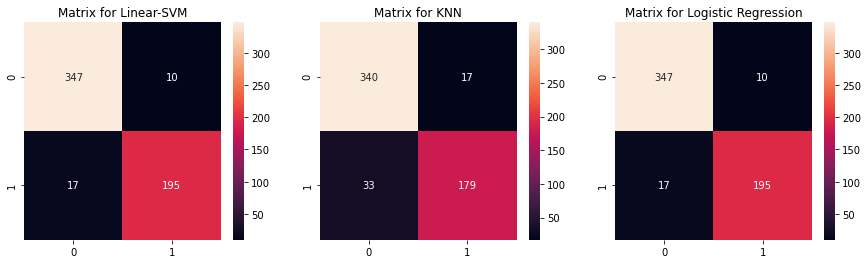

In [21]:
f, ax = plt.subplots(1, 3, figsize=(15, 4))

y_pred = cross_val_predict(svm.SVC(kernel="linear"), X, Y, cv=10)
sns.heatmap(metrics.confusion_matrix(Y, y_pred), ax=ax[0], annot=True, fmt="2.0f")
ax[0].set_title("Matrix for Linear-SVM")

y_pred = cross_val_predict(KNeighborsClassifier(n_neighbors=9), X, Y, cv=10)
sns.heatmap(metrics.confusion_matrix(Y, y_pred), ax=ax[1], annot=True, fmt="2.0f")
ax[1].set_title("Matrix for KNN")


y_pred = cross_val_predict(LogisticRegression(), X, Y, cv=10)
sns.heatmap(metrics.confusion_matrix(Y, y_pred), ax=ax[2], annot=True, fmt="2.0f")
ax[2].set_title("Matrix for Logistic Regression");

Главная диагональ показывает количество правильных прогнозов, сделанных для каждого класса, а правая диагональ показывает количество сделанных неверных прогнозов.

# Регрессия (Доделать)

In [22]:
# импортируем библиотеки
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV # Cross Validation специальная для гребневой регуляризации и Лассо
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

## Предобработка и визуализация данных 

In [23]:
df = pd.read_csv("RealEstate.csv")
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


Описание параметров: Прогноз цен на недвижимость 

parameter | description 
--- | --- 
X1 | Дата транзакции.
X2 | Возраст дома.
X3 | Расстояние до ближайшей станции MRT.
X4 | Общее количество круглосуточных магазинов.
X5 | Широта.
X6 | Долгота.
**Y**  | Цена дома.

**Y** - это выход и, следовательно, зависимая переменная.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


In [25]:
# Проверяем корреляцию
df.corr()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
No,1.000000,-0.048658,-0.032808,-0.013573,-0.012699,-0.010110,-0.011059,-0.028587
X1 transaction date,-0.048658,1.000000,0.017549,0.060880,0.009635,0.035058,-0.041082,0.087491
X2 house age,-0.032808,0.017549,1.000000,0.025622,0.049593,0.054420,-0.048520,-0.210567
X3 distance to the nearest MRT station,-0.013573,0.060880,0.025622,1.000000,-0.602519,-0.591067,-0.806317,-0.673613
X4 number of convenience stores,-0.012699,0.009635,0.049593,-0.602519,1.000000,0.444143,0.449099,0.571005
X5 latitude,-0.010110,0.035058,0.054420,-0.591067,0.444143,1.000000,0.412924,0.546307
X6 longitude,-0.011059,-0.041082,-0.048520,-0.806317,0.449099,0.412924,1.000000,0.523287
Y house price of unit area,-0.028587,0.087491,-0.210567,-0.673613,0.571005,0.546307,0.523287,1.000000


In [26]:
# Проверка на количество Null в столбцах
df.isnull().sum()

No                                        0
X1 transaction date                       0
X2 house age                              0
X3 distance to the nearest MRT station    0
X4 number of convenience stores           0
X5 latitude                               0
X6 longitude                              0
Y house price of unit area                0
dtype: int64

In [27]:
# Удаляем столбцы с номером и датой транзакции
df.drop(["X1 transaction date", "No"], axis=1, inplace= True)

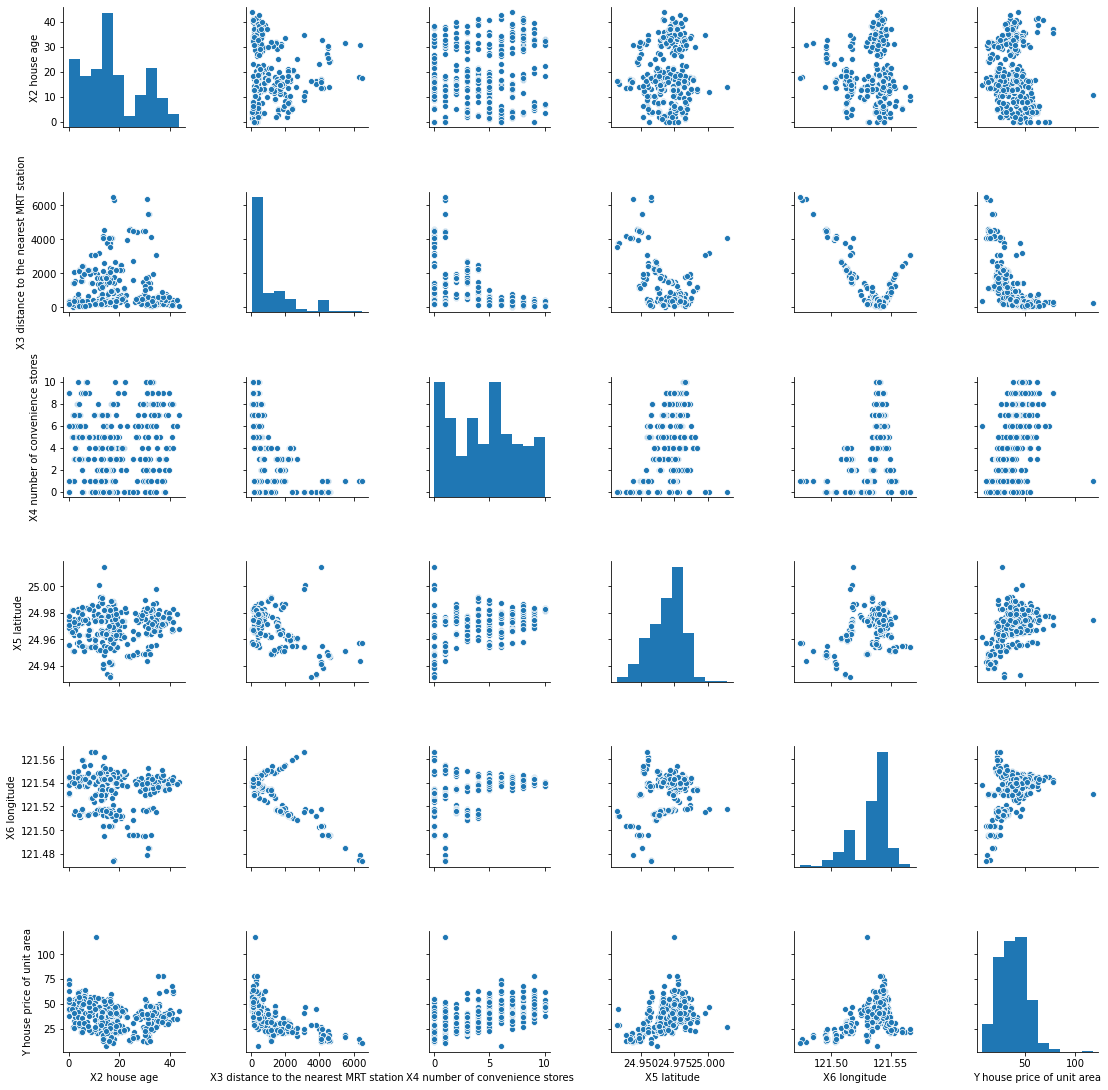

In [28]:
sns.pairplot(df);

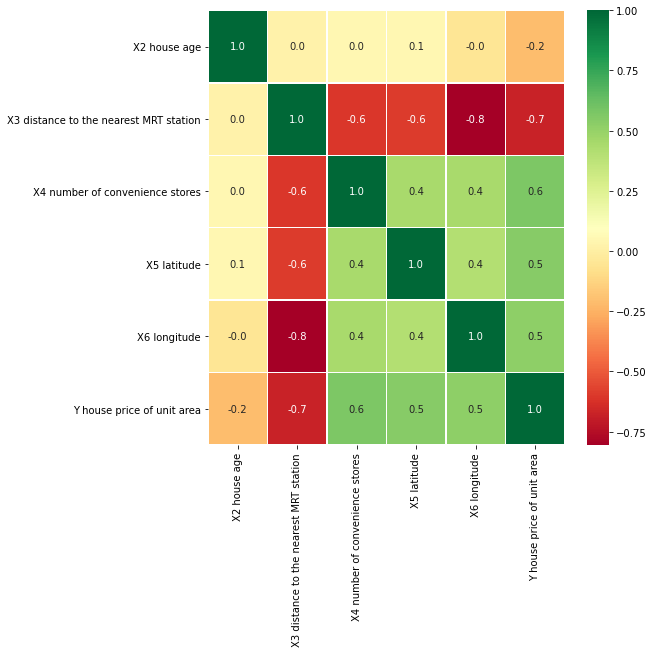

In [29]:
# визуализирует корреляцию с помощью heatmap 
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, cmap="RdYlGn", linewidths=.5, fmt= '.1f',ax=ax);

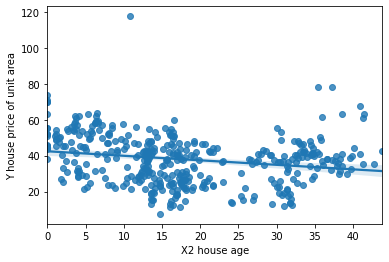

In [37]:
# Визуализация результата набора данных обучения
sns.regplot(x="X2 house age", y="Y house price of unit area", data=df);

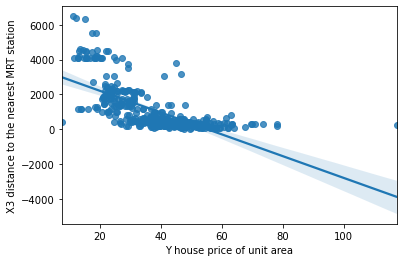

In [38]:
sns.regplot(y="X3 distance to the nearest MRT station", x="Y house price of unit area", data=df);

In [30]:
# Делим параметры на зависимые (y) и независимые (X)
X = df.loc[:,'X2 house age' : 'X6 longitude']
y = df.loc[:,'Y house price of unit area']

In [31]:
# Разделяем выборку на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3,random_state = 0)

## Регрессия на основе k-ближайших соседей.

In [32]:
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [33]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, knn_model.predict(X_test))))

MSE=9.206600


## Линейная регрессия

In [34]:
# Обучаем модель
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [35]:
# Коэффициенты регрессии 
pd.DataFrame(reg.coef_, index=X.columns, columns=['coef']).sort_values(by=['coef'], ascending= False)

,coef
X5 latitude,245.047983
X4 number of convenience stores,1.048201
X3 distance to the nearest MRT station,-0.004346
X2 house age,-0.280568
X6 longitude,-6.053154


In [36]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, reg.predict(X_test))))

MSE=8.579388


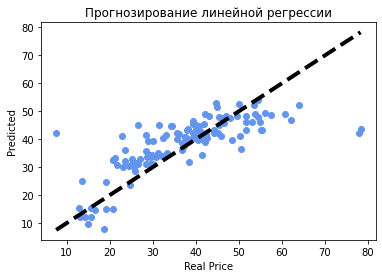

In [39]:
# График прогнозов реальной цены и предсказанной
plt.scatter(y_test, reg.predict(X_test), color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Real Price')
plt.ylabel('Predicted')
plt.title('Прогнозирование линейной регрессии');

## SVR. Регрессия опорных векторов

In [40]:
svr_model = make_pipeline(StandardScaler(), svm.SVR(C=2.5, epsilon=0.2))
svr_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(C=2.5, epsilon=0.2))])

In [41]:
print("MSE=%f" % np.sqrt(metrics.mean_squared_error(y_test, svr_model.predict(X_test))))

MSE=8.351585


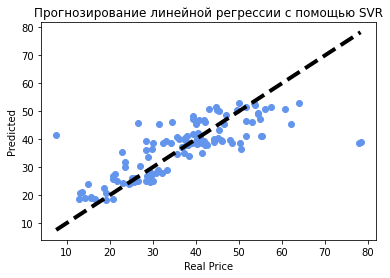

In [43]:
# График прогнозов реальной цены и предсказанной
plt.scatter(y_test, svr_model.predict(X_test), color='cornflowerblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Real Price')
plt.ylabel('Predicted')
plt.title('Прогнозирование линейной регрессии с помощью SVR');